# IGP 5 Models

## Feature Importance Evaluation

In [18]:
# load functions in python file with magic command
%run ../code/feature-importance.py

### Evaluation with SHAP and VIF

Using `SHAP` (SHapley Additive exPlanations):
* cooperative game theory which calculates contribution of each feature to the prediction
* can be used on any model
* positive values mean feature contributes to increasing the prediction; negative value decreases predition

Using `VIF` (Variance Inflation Factor):
* measure to quantify severity of multicollinearity -highly correlated features which lead to unreliable estimates of regression coefficient
* high VIF (greater than 5, 10) suggest that multicollinearity may be an issue - redundant feature or highly correlated


### Evaluation with wrapper, filter, embedded

* **filter**
  * evaluates performance of each model after selecting top_n (5) features using `SelectKBest` with ANOVA F-value as the scoring function
  * selects features based on individual relevance to target
* **wrapper**
  * evaluates performance of each model after selecting top_n (5) featues using `Recursive Feature Elimination` (RFE) with cross-validation
  * selects features baased on contribution to model performance
  * some models cannot be assessed with this, e.g. `QDA`
* **embedded**
  * evaluates performance of each model after training on entire dataset without feature selection
  * trains models with feature selection built into learning process

## Correlation Matrix


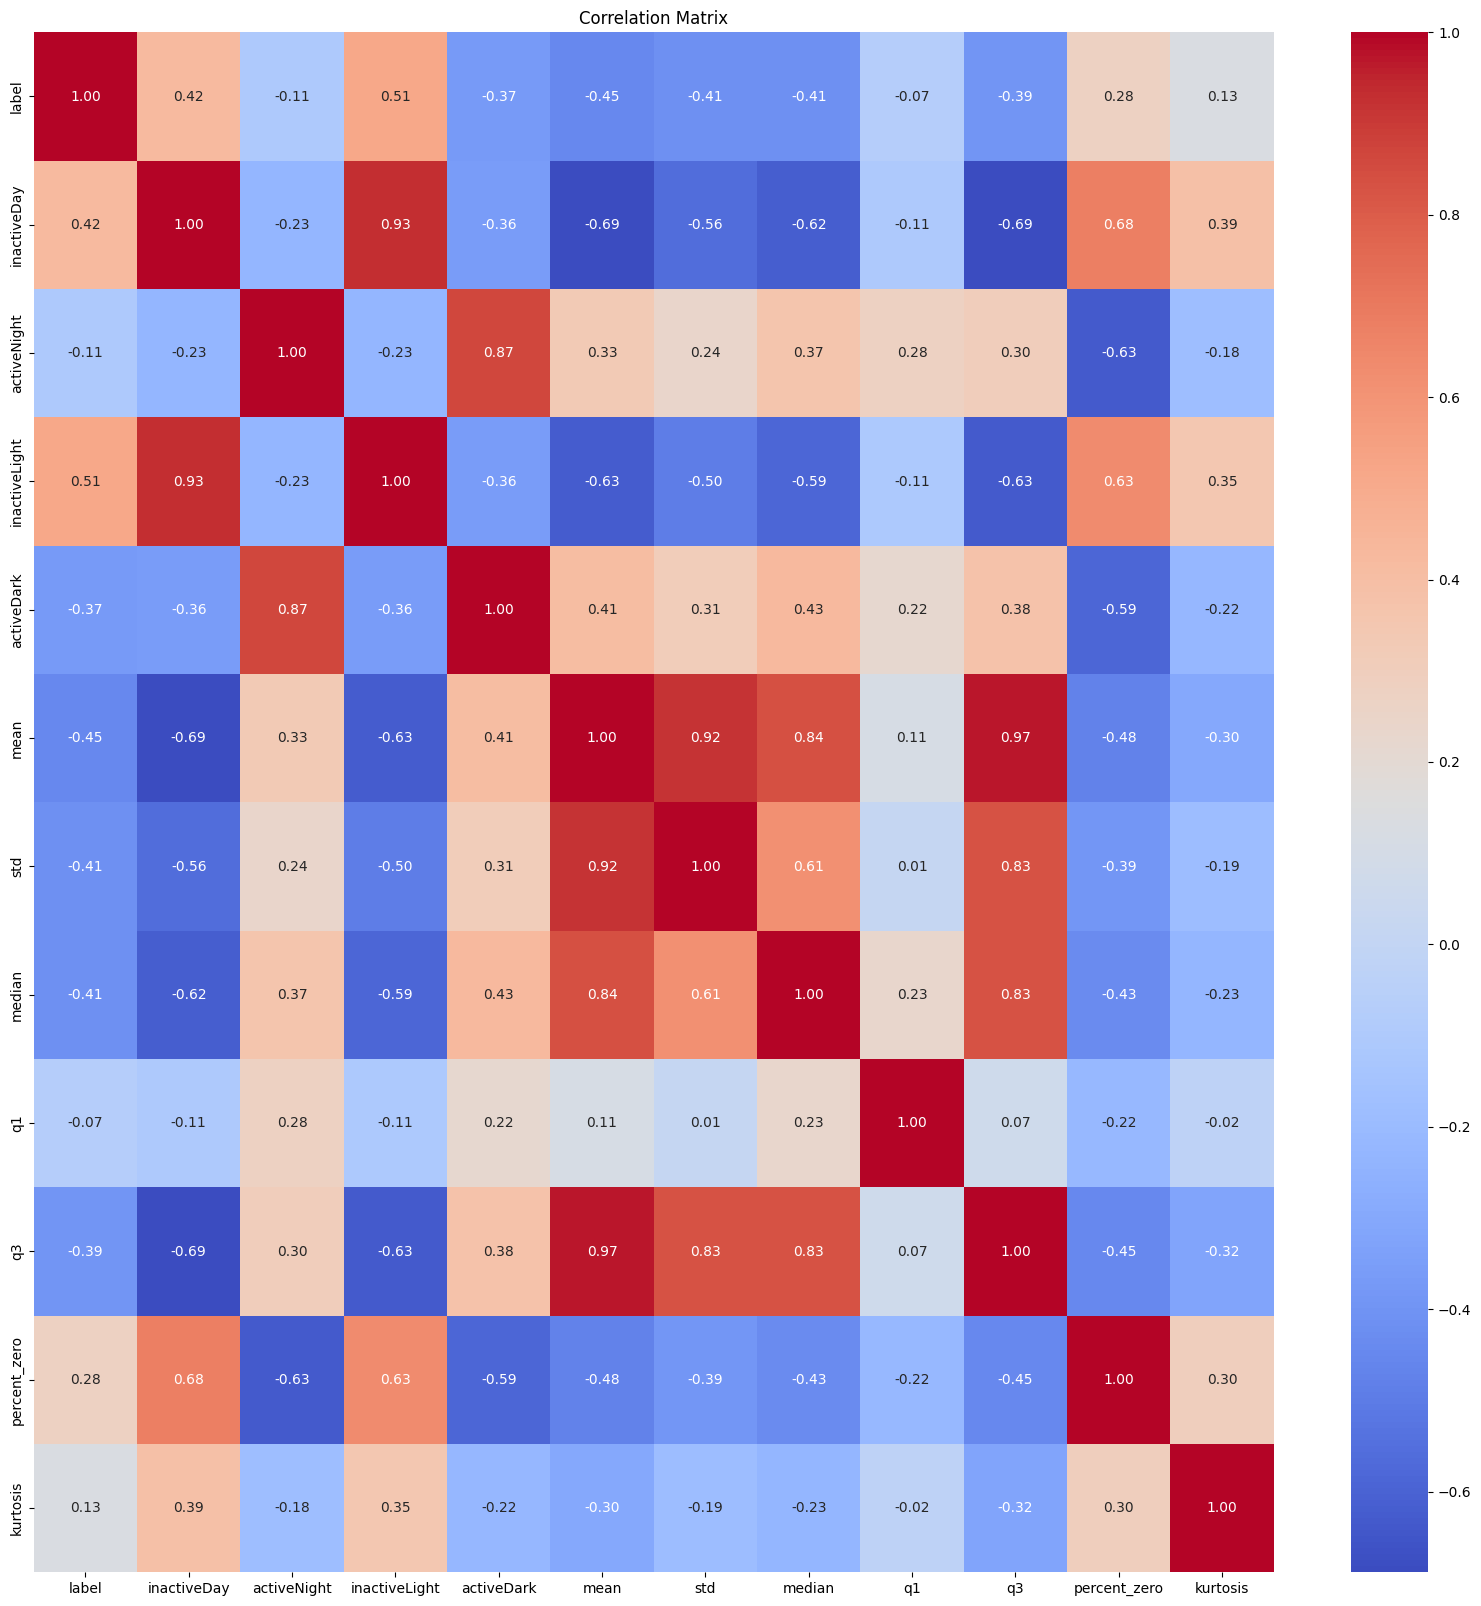

In [27]:
# read both (all)
both = pd.read_csv(output_csv_path + 'both.csv')

# plot correlation matrix
correlation_matrix = both.corr(method='pearson')
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


**Correlation Matrix**

*Highly correlated*
* inactiveLight / inactiveDay
* activeDark / activeNight
* mean / q3
* mean / median
* q3 / std
* q3 / median


Because the goal is a simple model which is interpretable, I am opting for dropping features instead of `Principal Component Analysis` - which is dimensionality reduction but keeping features.

### Male Dataset

`QDA`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round.

In [4]:
# read from csv
male_X_train = pd.read_csv(output_csv_path + 'male_X_train.csv')
male_y_train = pd.read_csv(output_csv_path + 'male_y_train.csv').iloc[:, 0]

In [15]:
# fit each model
for model_name, model in models_male:
    model.fit(male_X_train, male_y_train)

In [9]:
male_vif = calculate_vif(male_X_train)
print(male_vif.sort_values(by='VIF', ascending=False))

                       VIF
mean           2355.738968
std             660.620438
q3              376.903434
activeNight      56.697424
activeDark       46.564577
median           44.982132
inactiveDay      33.238402
inactiveLight    30.598657
percent_zero     12.648110
kurtosis          2.511157
q1                2.458344


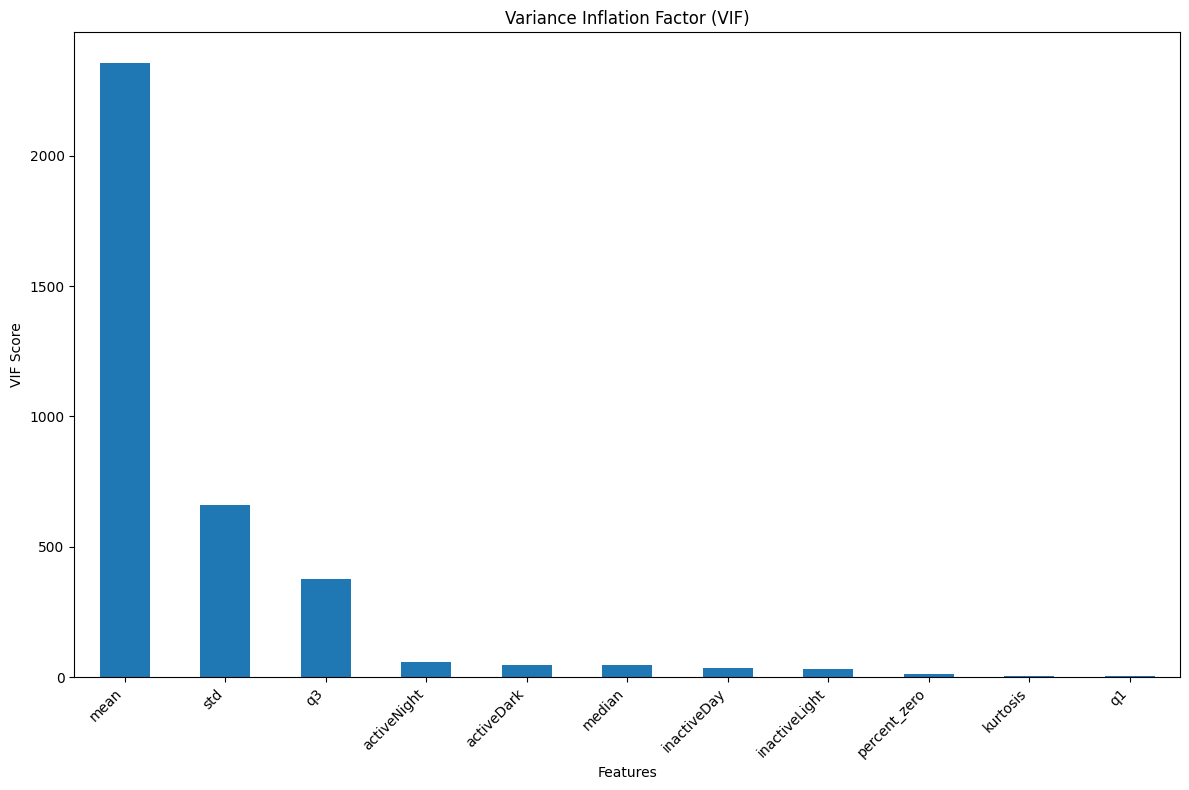

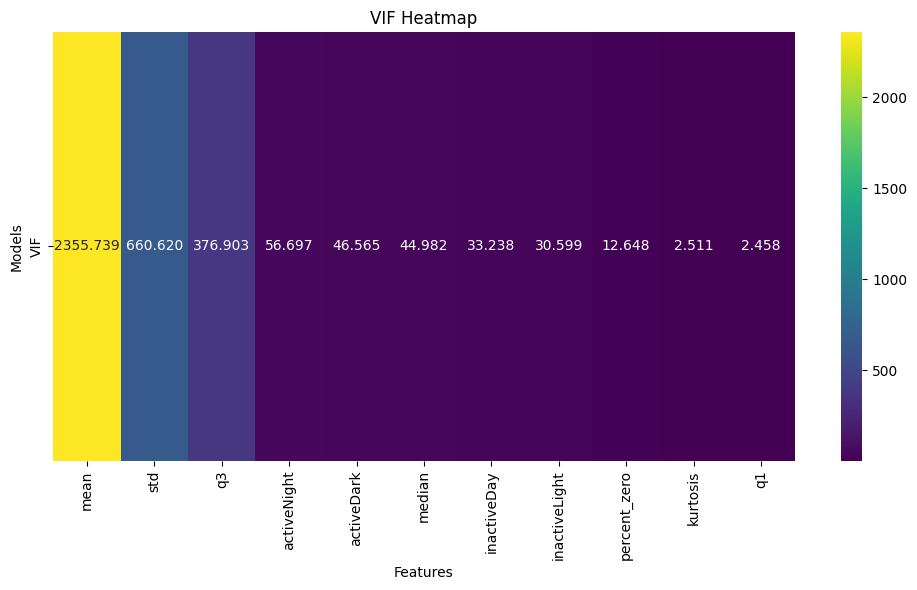

In [10]:
# bar plot vif
plot_vif(male_vif)

# heatmap vif
plot_vif_heatmap(male_vif)

In [20]:
# fit each model
for model_name, model in models_male:
    model.fit(male_X_train, male_y_train)

# shap values for male model
male_shap = calculate_shap_feature_importance(models_male, male_X_train, shap_sampling='auto')

Using 263 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/263 [00:00<?, ?it/s]

Using 263 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/263 [00:00<?, ?it/s]

Using 263 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/263 [00:00<?, ?it/s]

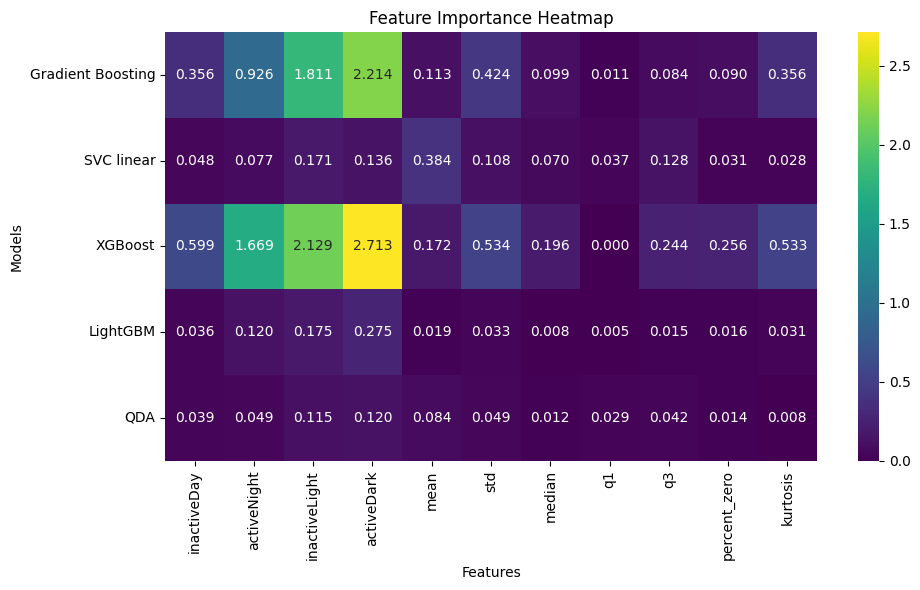

<Figure size 1000x600 with 0 Axes>

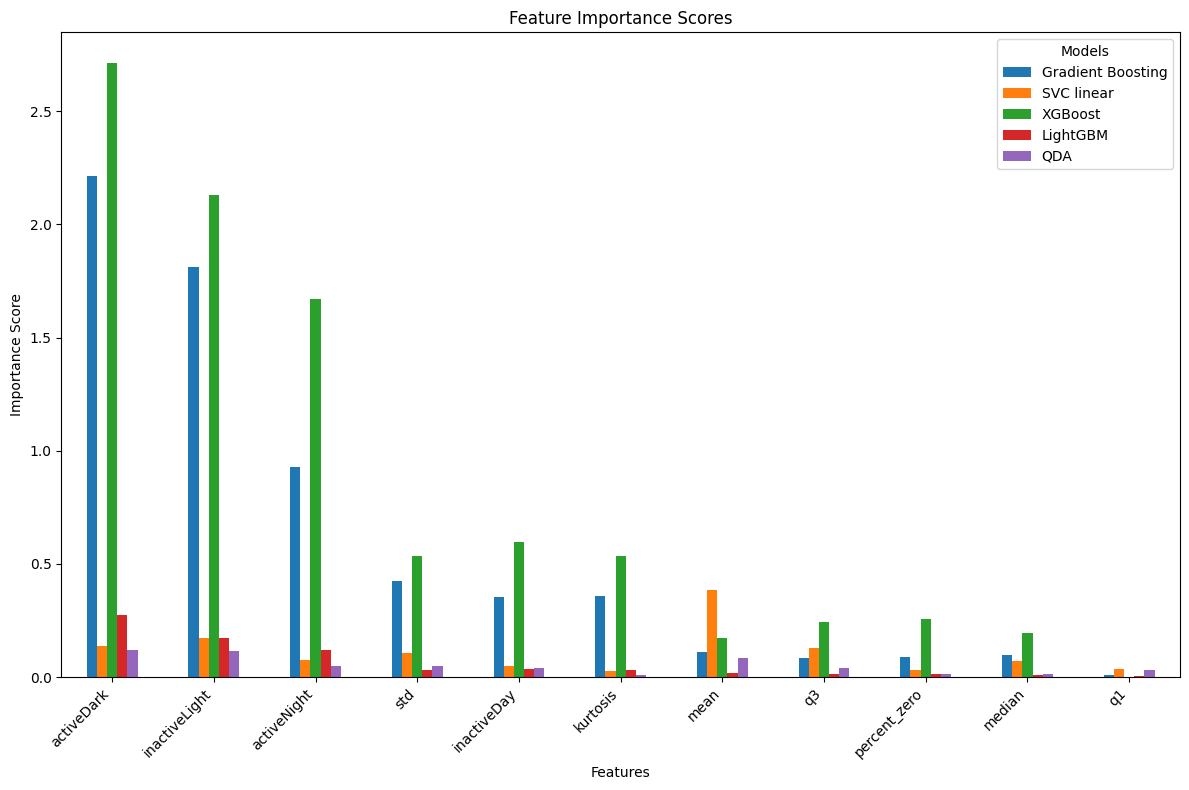

In [141]:
# Sshap heatmap
plot_feature_importance_heatmap(male_shap)
# plot feature importance for each model
plot_feature_shap(male_shap)

#### Interpretation

**VIF**

* as expected high multicollinearity - most features are highly correlated
* `mean` and `q3` are likely redundant given the distribution
* `activeNight` and `activeDark` are going to be very similar
* `inactiveDay` and `inactiveLight` are going to be very similar

Initial proposal: 
* drop `mean`, `activeDark`, `inactiveLight`
  * rationale is that dark and light features require more calculation than the simpler time-based night/day

**SHAP**

* Tree based explainer favoured `activeDark`, `inactiveLight` and `activeNight`

In [98]:
# reesults
filter_results, filter_feat_idx = filter_method(male_X_train, male_y_train, models_male)

{'Gradient Boosting': 0.8250362844702467, 'SVC linear': 0.7866473149492018, 'XGBoost': 0.8365021770682148, 'LightGBM': 0.8440493468795355, 'QDA': 0.8212626995645863}


{'filter': array([0, 2, 3, 4, 6], dtype=int64)}


In [79]:
wrapper_results, wrap_feat_idx = wrapper_method(male_X_train, male_y_train, models_male)

{'Gradient Boosting': 0.862699564586357, 'SVC linear': 0.8327285921625546, 'XGBoost': 0.8550072568940493, 'LightGBM': 0.8739477503628447, 'QDA': 0.8931059506531206}


{'Gradient Boosting': array([0, 1, 2, 3, 6], dtype=int64), 'SVC linear': array([0, 1, 2, 3, 7], dtype=int64), 'XGBoost': array([ 1,  2,  3,  9, 10], dtype=int64), 'LightGBM': array([ 1,  2,  3,  8, 10], dtype=int64)}


In [80]:
embedded_results, embed_feat_idx = embedded_method(male_X_train, male_y_train, models_male)

{'Gradient Boosting': 0.8513062409288825, 'SVC linear': 0.859288824383164, 'XGBoost': 0.870464441219158, 'LightGBM': 0.8701015965166908, 'QDA': 0.8931059506531206}


{'Gradient Boosting': array([ 2,  3,  1,  0, 10], dtype=int64), 'XGBoost': array([2, 3, 9, 1, 4], dtype=int64), 'LightGBM': array([ 3, 10,  2,  1,  8], dtype=int64)}


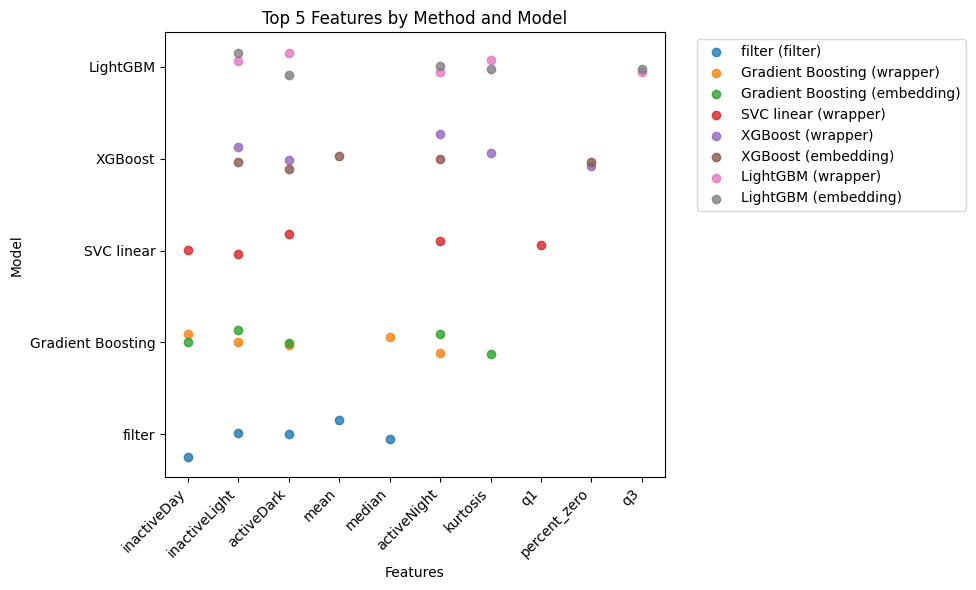

In [99]:
# plot
plot_feature_importance(filter_feat_idx, wrap_feat_idx, embed_feat_idx, male_X_train)

#### Interpretation for next round (reduced feature models)

* `LightGBM` - **inactiveLight**, **activeDark**, activeNight, ***kurtosis***, ***q3***
* `XGBoost` - **inactiveLight**, **activeDark**, activeNight, *kurtosis*, **percentZero**
* `SVC` - inactiveDay, inactiveLight, activeDark, activeNight, *q1*
* `Gradient Boosting` - **inactiveDay**, inactiveLight, activeDark, *median*, ***activeNight***, ***kurtosis***

* `standard deviation` was not important to any model
* 
**Taking to the next round:**

* *italics* not in male dataset
* **bold** progressing to next round


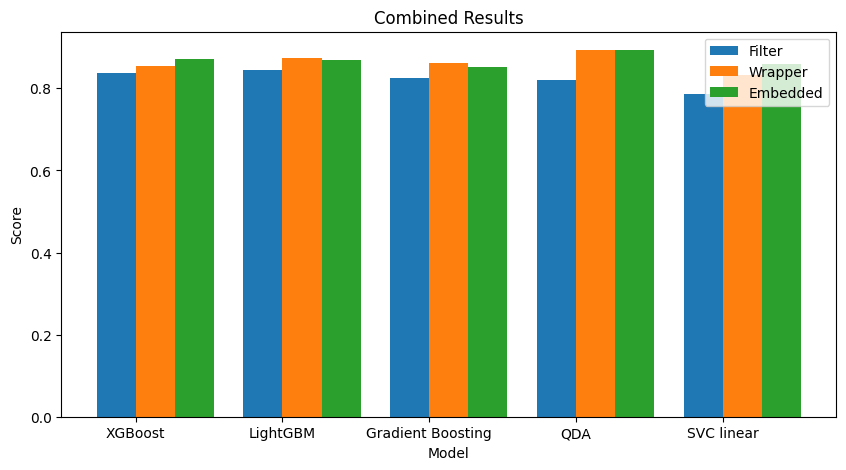

In [100]:
# bar plot
combine_and_plot_dicts(['Filter', 'Wrapper', 'Embedded'], filter_results, wrapper_results, embedded_results)

### Female Dataset

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `SVC linear` are top five models going to next round.

In [111]:
# read from csv
female_X_train = pd.read_csv(output_csv_path + 'female_X_train.csv')
female_y_train = pd.read_csv(output_csv_path + 'female_y_train.csv').iloc[:, 0]

In [112]:
# fit each model
for model_name, model in models_female:
    model.fit(female_X_train, female_y_train)

In [113]:
female_vif = calculate_vif(female_X_train)
print(female_vif.sort_values(by='VIF', ascending=False))

                       VIF
mean           1304.432493
std             361.120170
q3              212.545656
activeNight      66.514864
activeDark       62.632523
inactiveDay      25.857034
median           24.482410
inactiveLight    16.373850
percent_zero     12.587463
kurtosis          2.368819
q1                1.373444


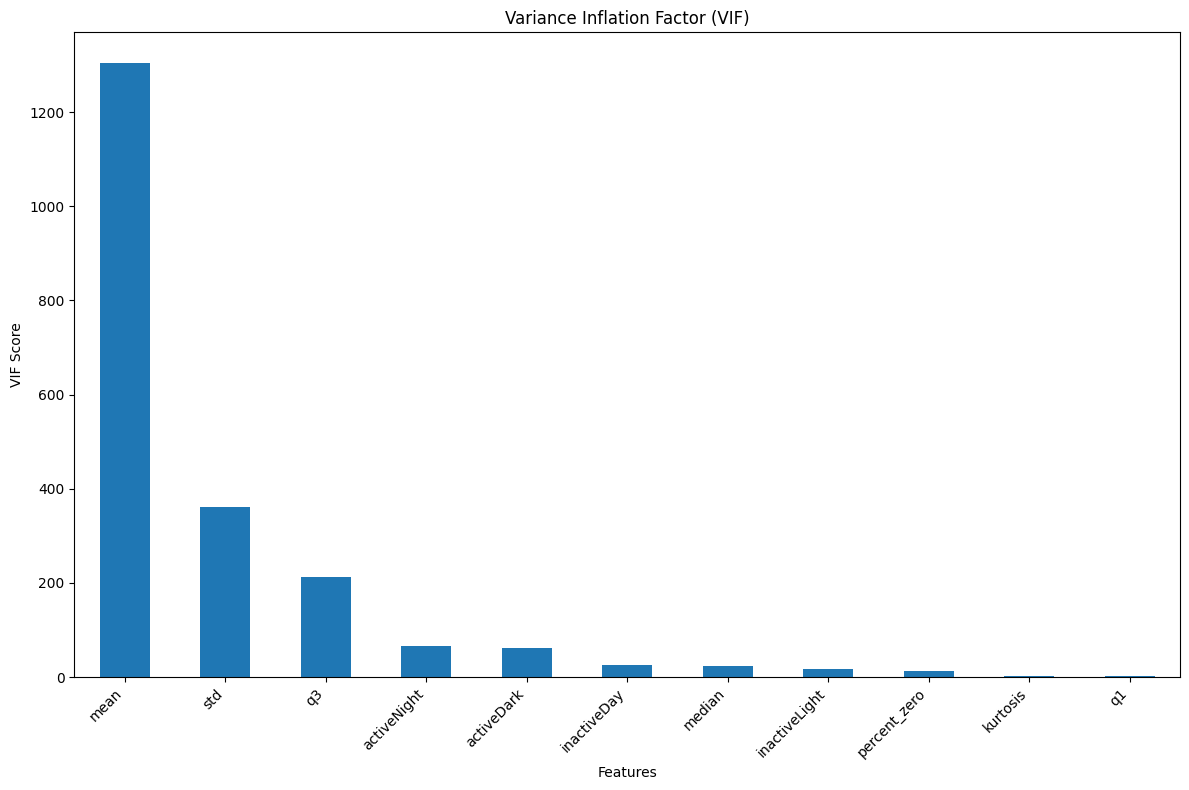

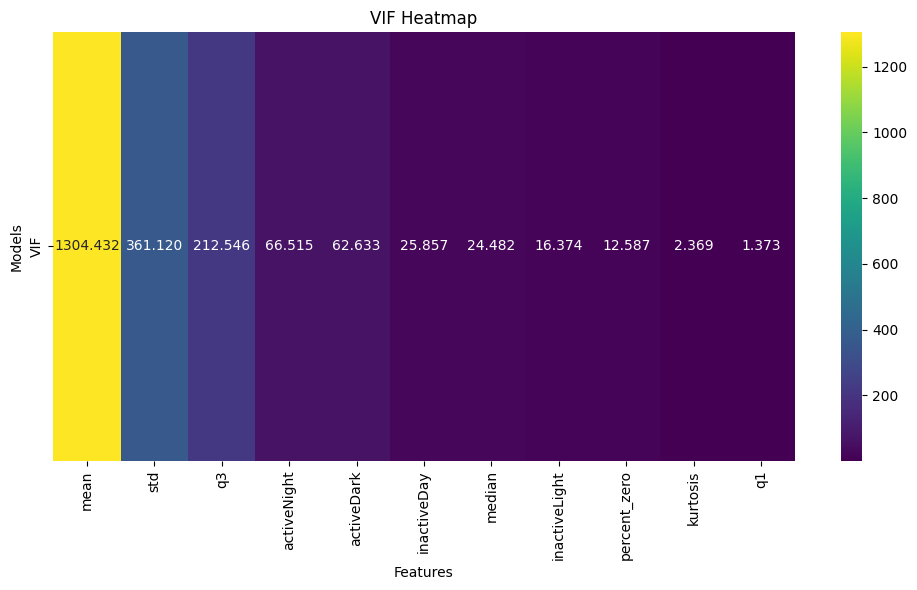

In [114]:
# bar plot vif
plot_vif(female_vif)

# heatmap vif
plot_vif_heatmap(female_vif)

In [126]:
# fit each model
for model_name, model in models_female:
    model.fit(female_X_train, female_y_train)

# shap values for female model
female_shap = calculate_shap_feature_importance(models_female, female_X_train, shap_sampling='auto')

Using 325 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/325 [00:00<?, ?it/s]

Using 325 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/325 [00:00<?, ?it/s]

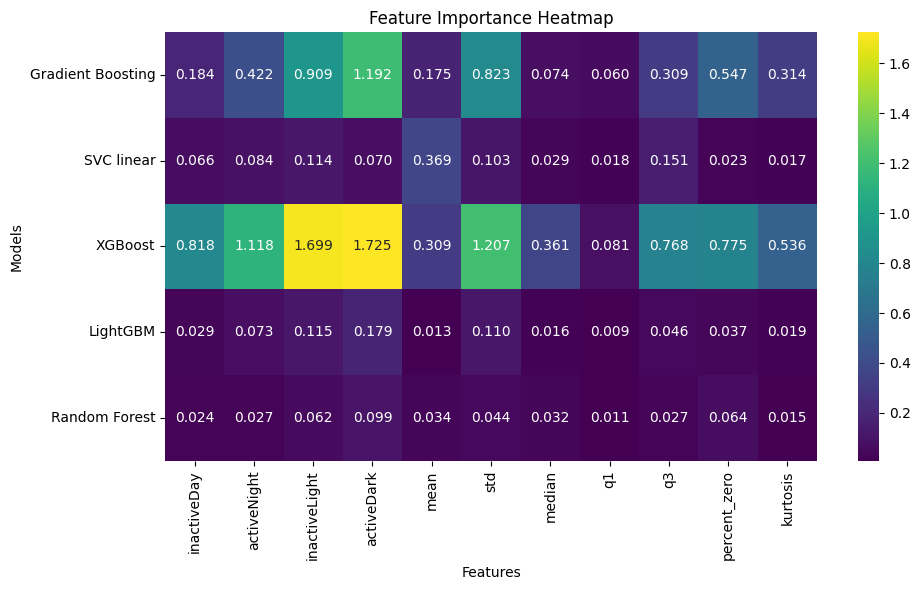

<Figure size 1000x600 with 0 Axes>

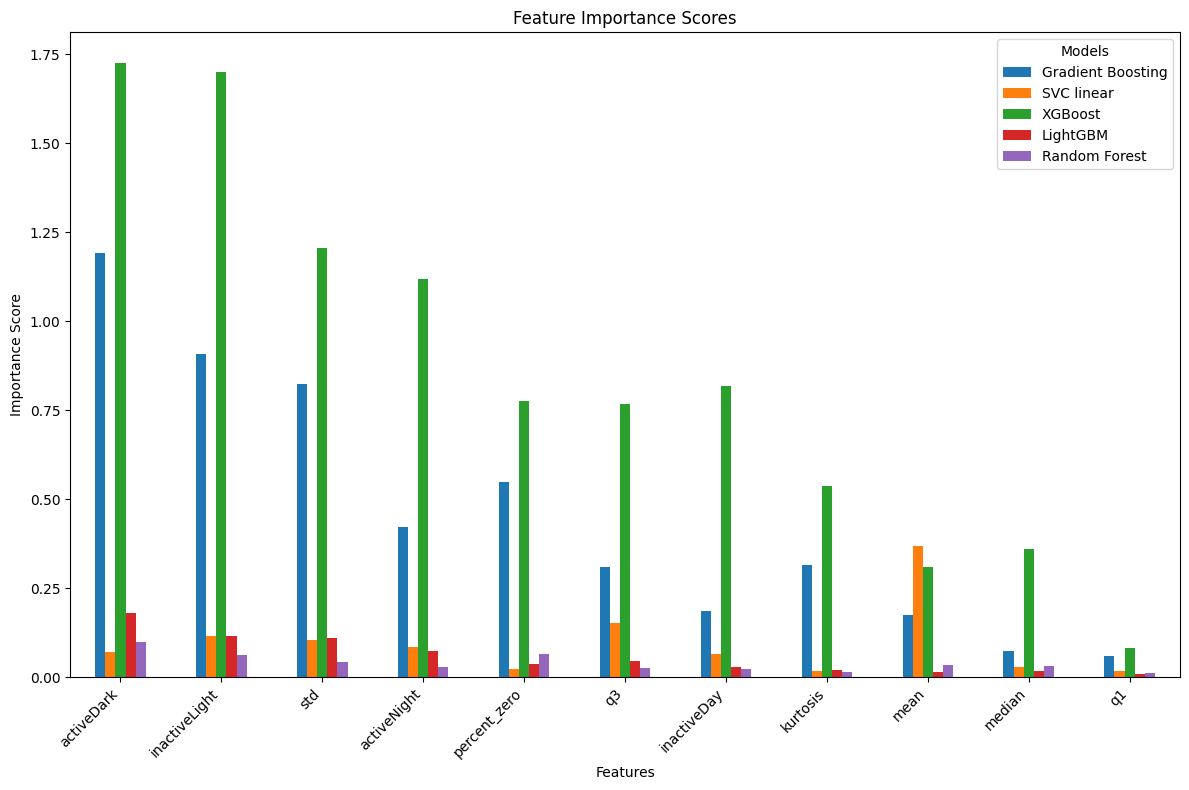

In [225]:
# Sshap heatmap
plot_feature_importance_heatmap(female_shap)
plot_feature_shap(female_shap)

#### Interpretation

**VIF**

* as expected high multicollinearity - most features are highly correlated
* `mean` and `q3` are likely redundant given the distribution
* `activeNight` and `activeDark` are going to be very similar
* `inactiveDay` and `inactiveLight` are going to be very similar

Initial proposal: 
* drop `mean`, `activeDark`, `inactiveLight`
  * rationale is that dark and light features require more calculation than the simpler time-based night/day

**SHAP**

* Tree based explainer favoured `inactiveLight` and `activeNight`


Compared to male:

* `percent_zero` and `kurtosis` are more important

In [142]:
# reesults
filter_results, filter_feat_idx = filter_method(female_X_train, female_y_train, models_female)

{'Gradient Boosting': 0.7661538461538462, 'SVC linear': 0.7846153846153846, 'XGBoost': 0.7630769230769231, 'LightGBM': 0.7630769230769231, 'Random Forest': 0.8}


{'filter': array([0, 2, 4, 5, 6], dtype=int64)}


In [143]:
wrapper_results, wrap_feat_idx = wrapper_method(female_X_train, female_y_train, models_female)

{'Gradient Boosting': 0.8461538461538461, 'SVC linear': 0.8215384615384617, 'XGBoost': 0.8215384615384614, 'LightGBM': 0.8338461538461539, 'Random Forest': 0.8184615384615384}


{'Gradient Boosting': array([0, 2, 3, 5, 9], dtype=int64), 'SVC linear': array([0, 1, 2, 3, 4], dtype=int64), 'XGBoost': array([1, 2, 3, 5, 7], dtype=int64), 'LightGBM': array([0, 1, 2, 3, 5], dtype=int64), 'Random Forest': array([2, 3, 5, 6, 9], dtype=int64)}


In [144]:
embedded_results, embed_feat_idx = embedded_method(female_X_train, female_y_train, models_female)

{'Gradient Boosting': 0.8615384615384615, 'SVC linear': 0.8246153846153847, 'XGBoost': 0.8492307692307692, 'LightGBM': 0.8430769230769231, 'Random Forest': 0.8461538461538461}


{'Gradient Boosting': array([3, 5, 2, 9, 0], dtype=int64), 'XGBoost': array([7, 3, 5, 2, 9], dtype=int64), 'LightGBM': array([3, 2, 1, 5, 0], dtype=int64), 'Random Forest': array([3, 6, 9, 2, 4], dtype=int64)}


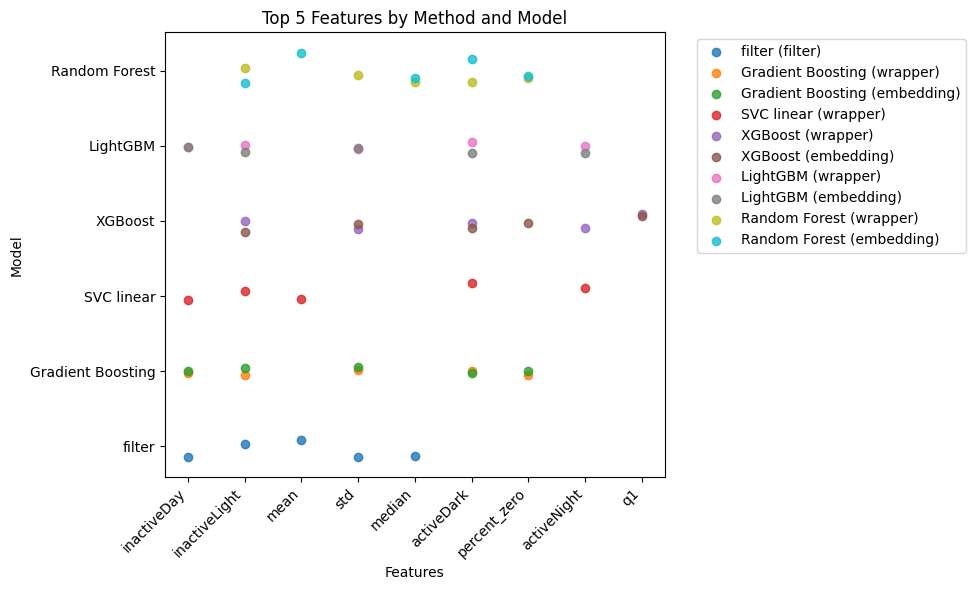

In [146]:
# plot
plot_feature_importance(filter_feat_idx, wrap_feat_idx, embed_feat_idx, female_X_train)

#### Interpretation for next round (reduced feature models)

* `LightGBM` - **inactiveLight**, **activeDark**, activeNight, ***std***, *inactiveDay*
* `XGBoost` - **inactiveLight**, ***std***, **activeDark**, activeNight, ***q1***, percentZero
* `SVC` - inactiveDay, inactiveLight, activeDark, activeNight, *mean*
* `Gradient Boosting` - inactiveDay, **inactiveLight**, ***std***, **activeDark**, ***percentZero***

* `q3` was not important to any model

**Taking to the next round:**

* *italics* not in male dataset
* **bold** progressing to next round

#### Both Dataset

`Random Forest`, `LightGBM`, `XGBoost`, `GradientBoosting` and `AdaBoost` are top five models going to next round.

In [148]:
# read from csv
both_X_train = pd.read_csv(output_csv_path + 'both_X_train.csv')
both_y_train = pd.read_csv(output_csv_path + 'both_y_train.csv').iloc[:, 0]

In [149]:
# fit each model
for model_name, model in models_both:
    model.fit(both_X_train, both_y_train)

both_vif = calculate_vif(both_X_train)
print(both_vif.sort_values(by='VIF', ascending=False))

                       VIF
mean           1492.602592
std             422.534144
q3              234.068662
activeNight      60.506221
activeDark       53.117331
median           29.220036
inactiveDay      27.481275
inactiveLight    19.232719
percent_zero     13.006381
kurtosis          2.614983
q1                1.446393


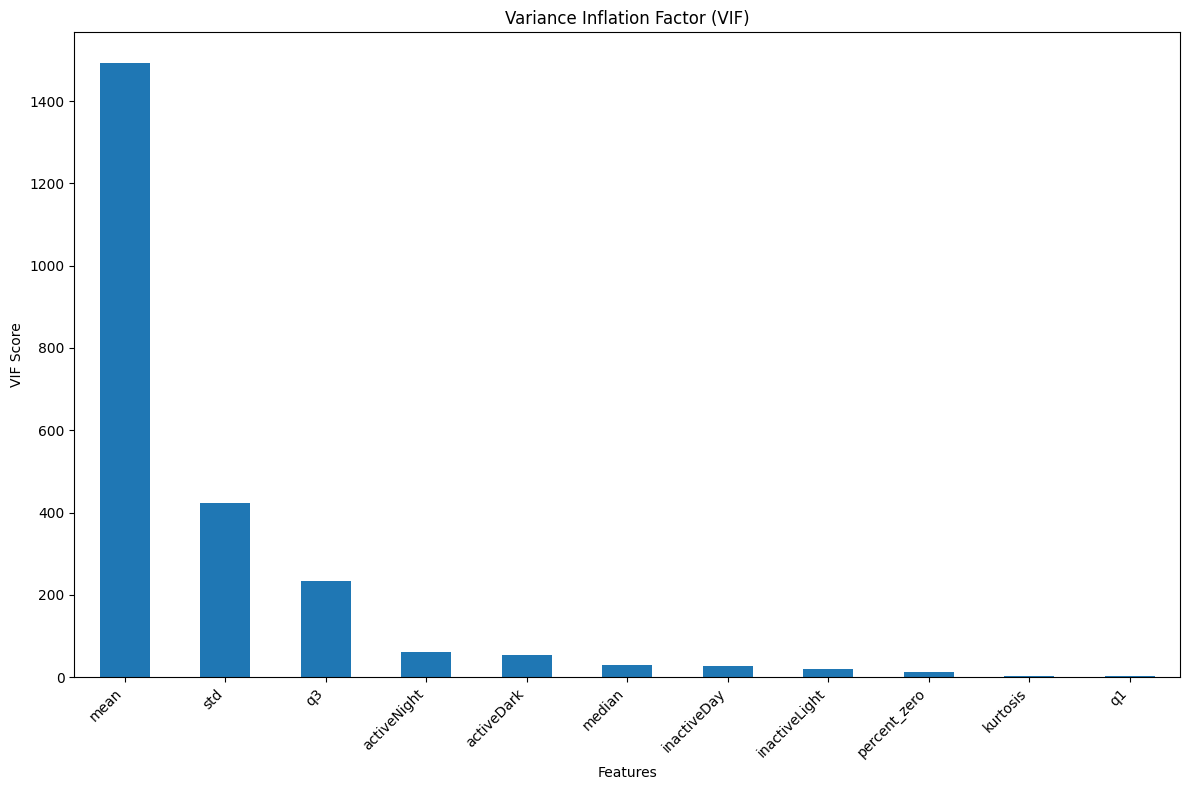

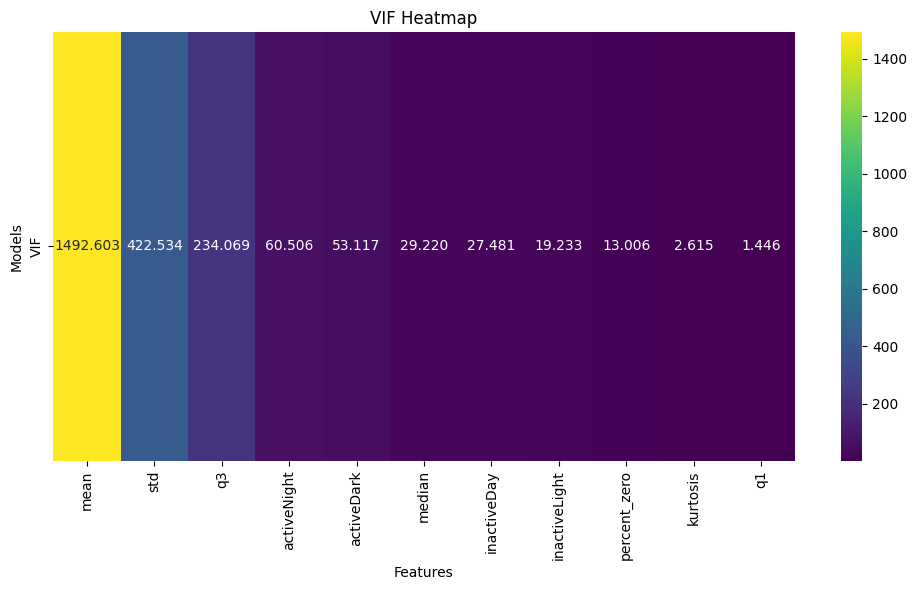

In [150]:
# bar plot vif
plot_vif(both_vif)

# heatmap vif
plot_vif_heatmap(both_vif)

In [235]:
models_both = [
    ('Gradient Boosting', GradientBoostingClassifier(random_state=RANDOM_STATE)),
   ('XGBoost', XGBClassifier(random_state=RANDOM_STATE)),
    ('LightGBM', LGBMClassifier(verbose=-1, random_state=RANDOM_STATE)),
    ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE))
    ,('AdaBoost', AdaBoostClassifier(algorithm='SAMME', random_state=RANDOM_STATE))
]

In [219]:
# fit each model
for model_name, model in models_both:
    model.fit(both_X_train, both_y_train)

# shap values for  model
both_shap = calculate_shap_feature_importance(models_both, both_X_train, shap_sampling='auto')

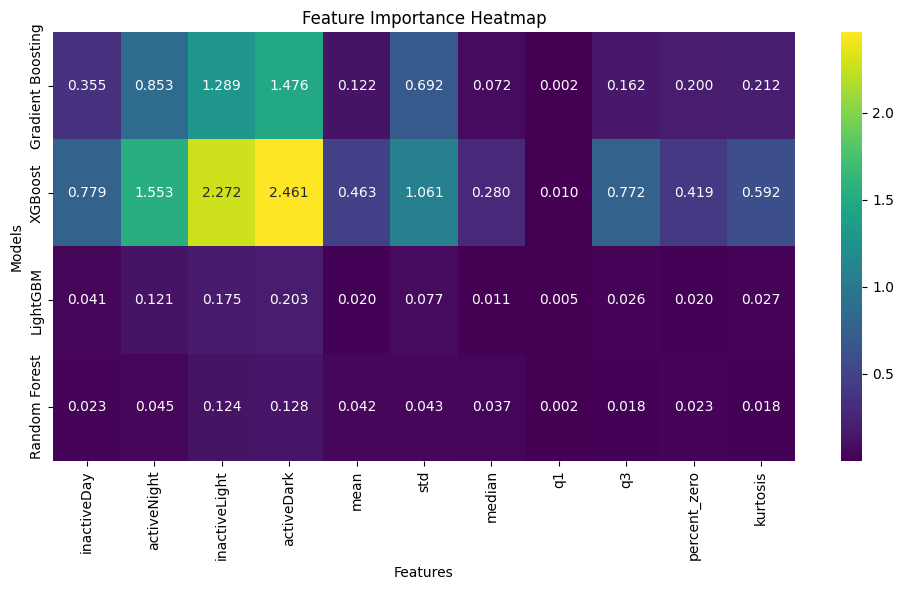

<Figure size 1000x600 with 0 Axes>

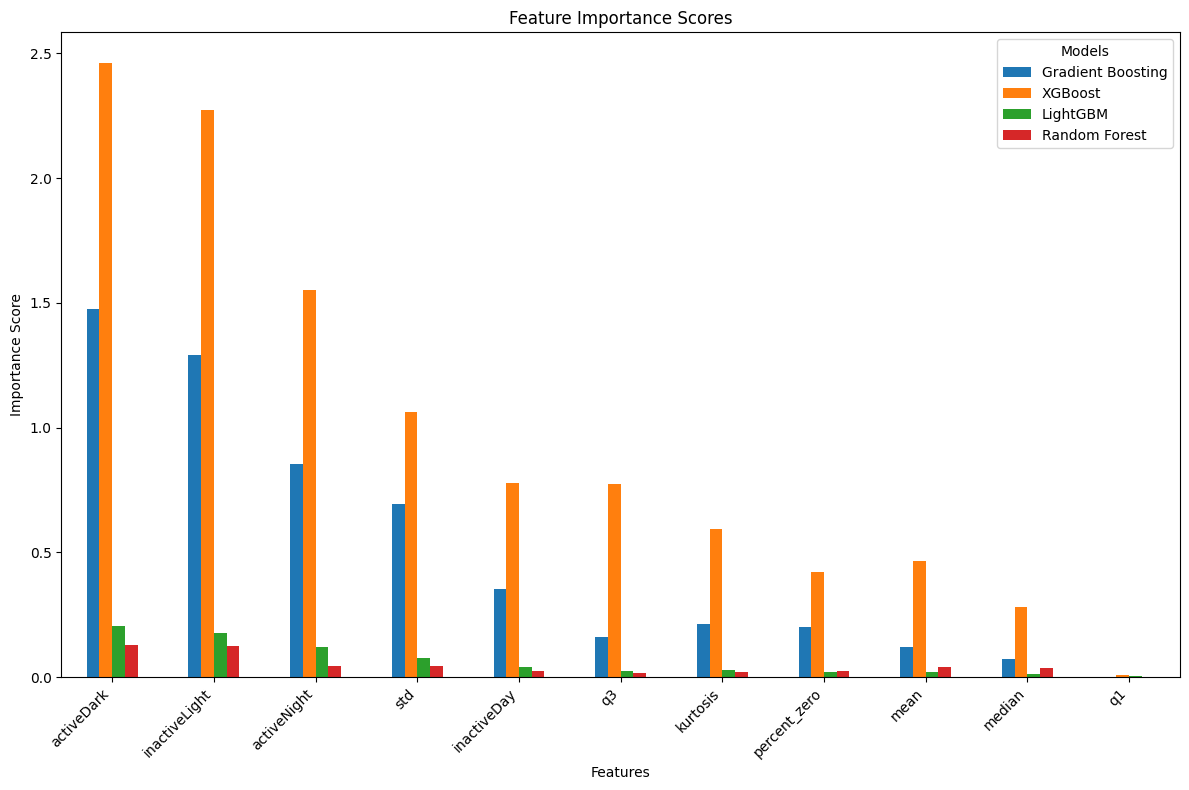

In [224]:
# Sshap heatmap
plot_feature_importance_heatmap(both_shap)
# plot feature importance for each model
plot_feature_shap(both_shap)

#### AdaBoost

`AdaBoost` is an ensemble of weak learners (combines decision trees) into a stronger classifier - thus it is not suitable for SHAP (unless using different explainers).  Instead, the feature importances using `AdaBoost` as classifier are below.

          feature  importance
3      activeDark    0.268664
2   inactiveLight    0.184276
1     activeNight    0.125003
5             std    0.121770
0     inactiveDay    0.086327
9    percent_zero    0.062922
10       kurtosis    0.057008
4            mean    0.050782
6          median    0.043248
7              q1    0.000000
8              q3    0.000000


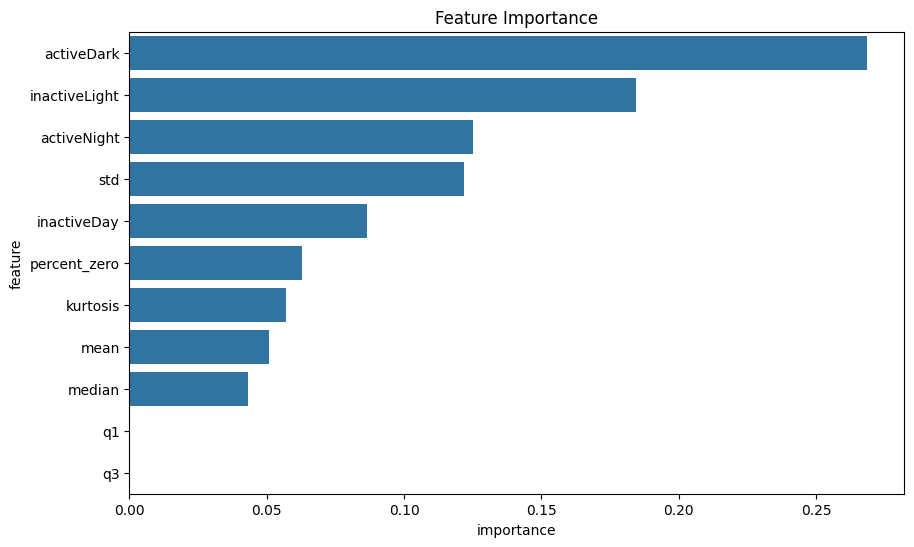

In [231]:
from sklearn.ensemble import AdaBoostClassifier

# Train your AdaBoost model
model = AdaBoostClassifier(algorithm='SAMME', random_state=RANDOM_STATE)
model.fit(both_X_train, both_y_train)

# Feature importances
feature_importances = model.feature_importances_

# Create DataFrame
feature_importance_df = pd.DataFrame({'feature': both_X_train.columns, 'importance': feature_importances})

#sort by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# print feature importance
print(feature_importance_df)

# plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()



#### Interpretation

**VIF**

* as expected high multicollinearity - most features are highly correlated
* `mean` and `q3` are likely redundant given the distribution
* `activeNight` and `activeDark` are going to be very similar
* `inactiveDay` and `inactiveLight` are going to be very similar

Initial proposal: 
* drop `mean`, `activeDark`, `inactiveLight`
  * rationale is that dark and light features require more calculation than the simpler time-based night/day

**SHAP**

* Tree based explainer favoured `activeDark`, `inactiveLight` and `activeNight`
* `AdaBoost` favours `activeDark`, `inactiveLight`, `activeNight`, `std`

In [236]:
# reesults
filter_results, filter_feat_idx = filter_method(both_X_train, both_y_train, models_both)

{'Gradient Boosting': 0.7538026944806606, 'XGBoost': 0.7520932927712588, 'LightGBM': 0.757221497899464, 'Random Forest': 0.7521222656815877, 'AdaBoost': 0.7809792843691149}


{'filter': array([0, 2, 4, 5, 6], dtype=int64)}


In [237]:
wrapper_results, wrap_feat_idx = wrapper_method(both_X_train, both_y_train, models_both)

{'Gradient Boosting': 0.8607851658699115, 'XGBoost': 0.8573518759959438, 'LightGBM': 0.855714906562364, 'Random Forest': 0.8505722149789946, 'AdaBoost': 0.8488772997247572}


{'Gradient Boosting': array([ 1,  2,  3,  5, 10], dtype=int64), 'XGBoost': array([1, 2, 3, 5, 7], dtype=int64), 'LightGBM': array([ 1,  2,  3,  5, 10], dtype=int64), 'Random Forest': array([2, 3, 4, 6, 9], dtype=int64), 'AdaBoost': array([0, 1, 2, 3, 5], dtype=int64)}


In [238]:
embedded_results, embed_feat_idx = embedded_method(both_X_train, both_y_train, models_both)

{'Gradient Boosting': 0.8743879472693031, 'XGBoost': 0.8743734608141388, 'LightGBM': 0.8794726930320149, 'Random Forest': 0.8556714471968709, 'AdaBoost': 0.8608286252354048}


{'Gradient Boosting': array([ 3,  2,  1,  5, 10], dtype=int64), 'XGBoost': array([2, 7, 3, 1, 5], dtype=int64), 'LightGBM': array([ 3,  2, 10,  1,  0], dtype=int64), 'Random Forest': array([3, 2, 0, 6, 9], dtype=int64), 'AdaBoost': array([3, 2, 5, 1, 0], dtype=int64)}


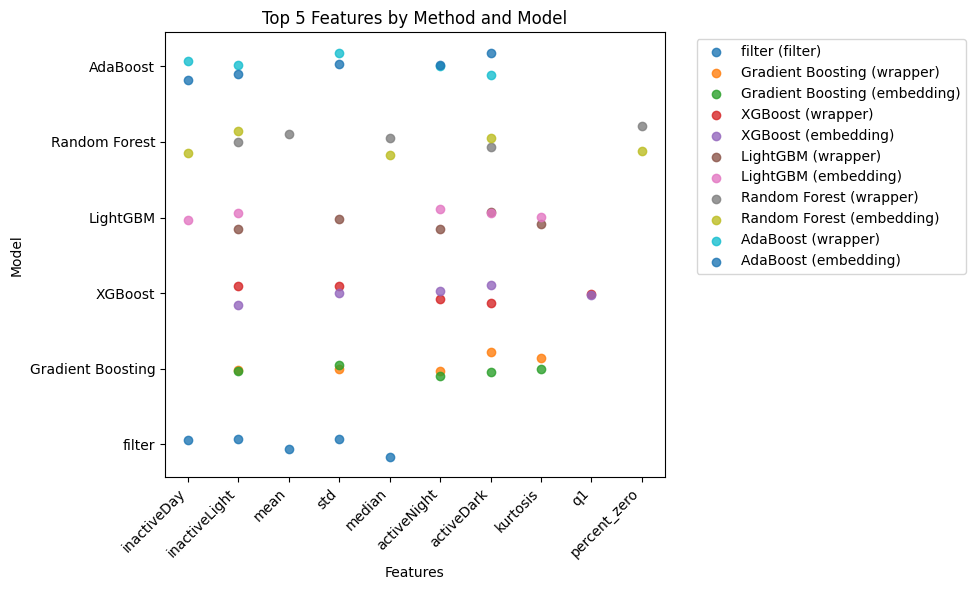

In [239]:
# plot
plot_feature_importance(filter_feat_idx, wrap_feat_idx, embed_feat_idx, both_X_train)

#### Interpretation for next round (reduced feature models)

* `LightGBM` - **inactiveLight**, **activeNight**, **kurtosis**
* `XGBoost` - **inactiveLight**, **std**, **activeDark**, **activeNight**, **q1**
* `AdaBoost` - **inactiveDay**, **inactiveLight**, **activeDark**, **activeNight**, **std**
* `Gradient Boosting` -  **inactiveLight**, **kurtosis**, **activeNight**, **activeDark**
* `Random Forest` - **inactiveLight**, **median**, **activeDark**

* `q3` was not important to any model

**Taking to the next round:**


* **bold** progressing to next round